In [12]:
import json
import pandas as pd
import networkx as nx
from networkx.algorithms import community
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import os
import sys 
sys.path.insert(1, '../congress_network')

from viral_centrality import viral_centrality

In [13]:
# Data
f = open(r'../congress_network/congress_network_data.json')
data = json.load(f)

inList = data[0]['inList']
inWeight = data[0]['inWeight']
outList = data[0]['outList']
outWeight = data[0]['outWeight']
usernameList = data[0]['usernameList']

# Attributs
attributes_df = pd.read_csv('../congress_network/congress_member_attributes.csv')
def recode_age(age) :
    if age<40 :
        return "Moins de 40 ans"
    elif age<50:
        return "40 à 49 ans"
    elif age<60:
        return "50 à 59 ans"
    elif age<70:
        return "60 à 69 ans"
    elif age<80:
        return "70 à 79 ans"
    else:
        return "Plus de 80 ans"
attributes_df["age_recode"] = attributes_df["age"].apply(recode_age)



In [14]:
attributes_df

,congress_member,sex,age,party,chamber,age_recode
0,SenatorBaldwin,F,60,D,S,60 à 69 ans
1,SenJohnBarrasso,H,70,R,S,70 à 79 ans
2,SenatorBennet,H,60,D,S,60 à 69 ans
3,MarshaBlackburn,F,70,R,S,70 à 79 ans
4,SenBlumenthal,H,76,D,S,70 à 79 ans
...,...,...,...,...,...,...
470,RepJoeWilson,H,75,R,Rep,70 à 79 ans
471,RobWittman,H,63,R,Rep,60 à 69 ans
472,rep_stevewomack,H,65,R,Rep,60 à 69 ans
473,RepJohnYarmuth,H,75,R,Rep,70 à 79 ans


### Stats descriptives sur les attributs

In [15]:
# On étudie la répartition des différentes classes
def summary_attribute(df) :
    for i in df.columns :
            print("Répartition de", i, "parmi les nodes:\n", attributes_df[i].value_counts(), "\n")
            
summary_attribute(attributes_df.drop(["congress_member", "age"], axis = 1))


Répartition de sex parmi les nodes:
 sex
H    334
F    141
Name: count, dtype: int64 

Répartition de party parmi les nodes:
 party
D    252
R    223
Name: count, dtype: int64 

Répartition de chamber parmi les nodes:
 chamber
Rep    383
S       92
Name: count, dtype: int64 

Répartition de age_recode parmi les nodes:
 age_recode
60 à 69 ans        149
50 à 59 ans        122
70 à 79 ans         92
40 à 49 ans         73
Moins de 40 ans     22
Plus de 80 ans      17
Name: count, dtype: int64 



In [30]:
def plot_bivariate(data, x, hue, hue_order) :
    sns.catplot(data = data, x = x, hue = hue, hue_order = hue_order,
                kind = 'count')

    sns.displot(data = data, x = x, hue = hue, hue_order = hue_order,
                stat='probability', multiple = "fill")

Comment sont répartis hommes et femmes au sein des partis ?


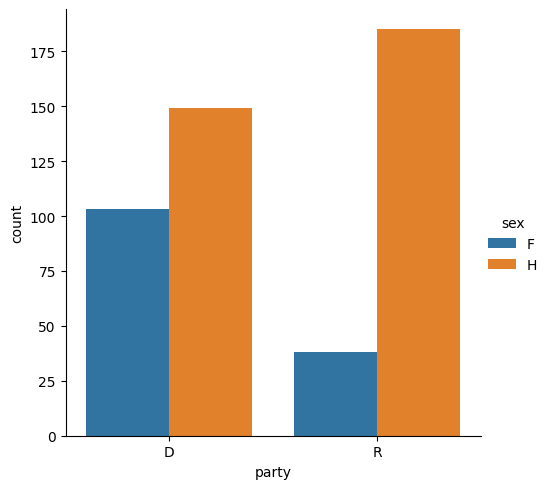

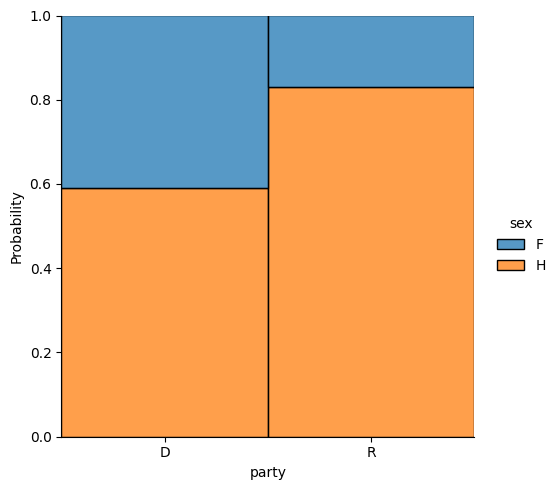

In [31]:
# Comment sont répartis hommes et femmes au sein des partis ?

print("Comment sont répartis hommes et femmes au sein des partis ?")
plot_bivariate(attributes_df, "party", "sex", ["F", "H"])



Comment sont répartis les âges au sein des partis ?


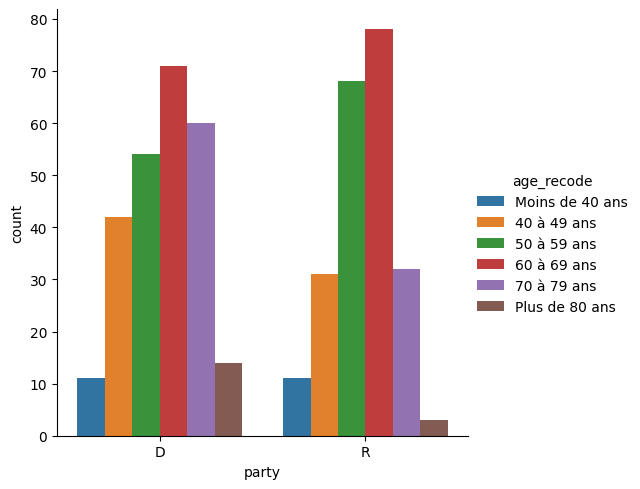

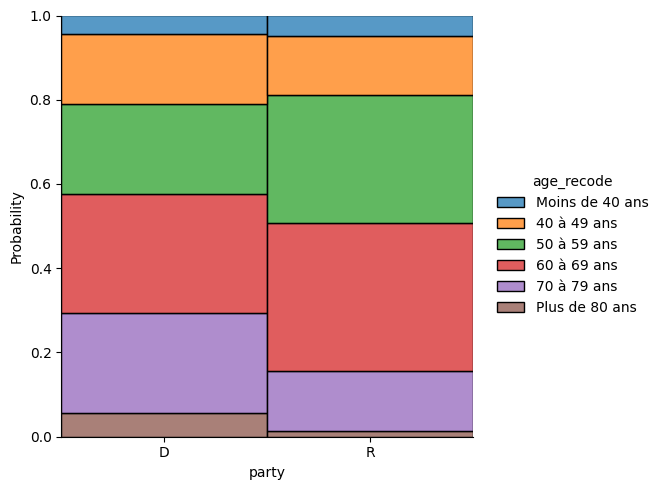

In [34]:
# Comment sont répartis les âges au sein des partis ?

print("Comment sont répartis les âges au sein des partis ?")
plot_bivariate(attributes_df, x = "party", hue = "age_recode", 
               hue_order = ["Moins de 40 ans", "40 à 49 ans", "50 à 59 ans", "60 à 69 ans", "70 à 79 ans", "Plus de 80 ans"])


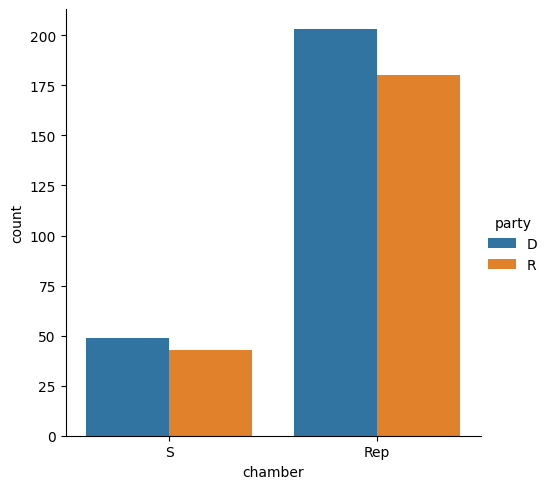

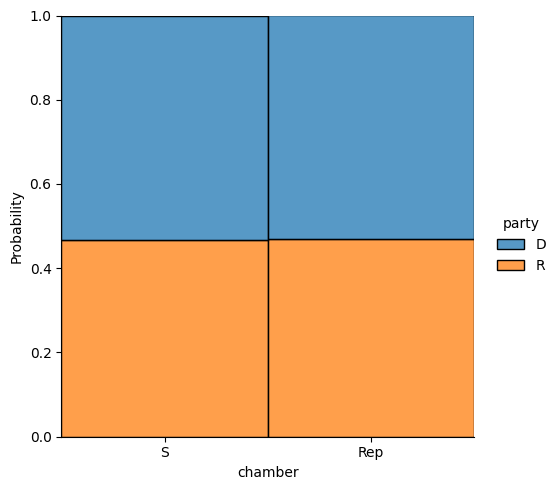

In [35]:
# Quelle répartition des partis au sein des chambres sur l'échantillon ? 
# En réalité, sénat majoritairement D, chambre des représentants majoritairement R

plot_bivariate(attributes_df, x = "chamber", hue = "party", hue_order = ["D", "R"])

Comment sont répartis les âges au sein des chambres ?


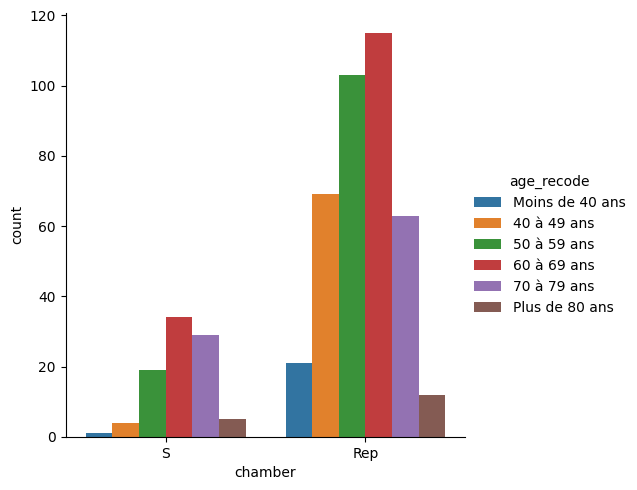

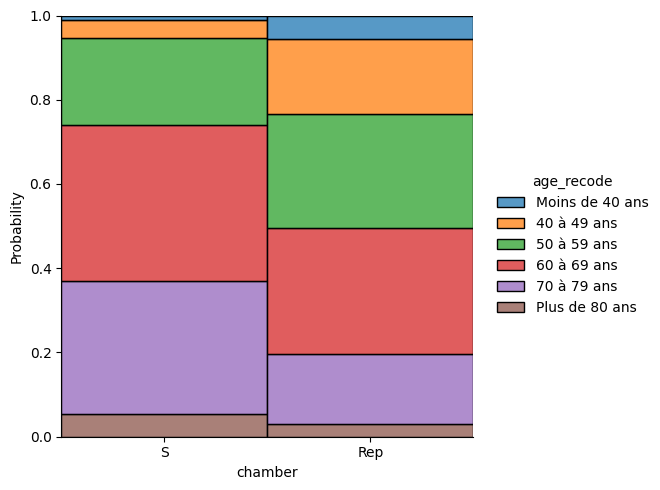

In [36]:
# Comment sont répartis les âges au sein des chambres ?

print("Comment sont répartis les âges au sein des chambres ?")

plot_bivariate(data = attributes_df, x = "chamber", hue = "age_recode", 
               hue_order = ["Moins de 40 ans", "40 à 49 ans", "50 à 59 ans", "60 à 69 ans", "70 à 79 ans", "Plus de 80 ans"])


On peut constater deux principaux points :
- Le groupe des démocrates est plus équilibré en terme de répartition hommes/femmes que le groupe républicain (~ 40% de femmes contre moins de 20%)
- Les sénateurs sont plus agés que les représentants

### Analyse de centralité

In [49]:
# Calculer la centralité de degré entrant
in_degree_centrality = [len(in_list) for in_list in inList]

# Calculer la centralité basée sur le poids des connexions entrantes
in_weighted_centrality_mean = [sum(weights)/len(weights) if len(weights)!=0 else 0 for weights in inWeight]
in_weighted_centrality_sum = [sum(weights) for weights in inWeight]

# Trouver les indices des 5 membres les plus centraux en termes de degré entrant
top_5_in_degree_indices = sorted(range(len(in_degree_centrality)), key=lambda i: in_degree_centrality[i], reverse=True)[:5]

# Trouver les indices des 5 membres les plus influents en termes de poids des connexions entrantes
top_5_in_weighted_indices_mean = sorted(range(len(in_weighted_centrality_mean)), key=lambda i: in_weighted_centrality_mean[i], reverse=True)[:5]
top_5_in_weighted_indices_sum = sorted(range(len(in_weighted_centrality_sum)), key=lambda i: in_weighted_centrality_sum[i], reverse=True)[:5]

# Afficher les résultats
print("Les résultats suivants sont ceux qui retweet le plus\n")

print("Les 5 membres les plus centraux (basé sur le degré entrant) sont :")
for i in top_5_in_degree_indices:
    print(f"{usernameList[i]} (centralité de degré entrant = {in_degree_centrality[i]})")

print("\nLes 5 membres les plus influents (basé sur le poids des connexions entrantes) sont :")
for i in top_5_in_weighted_indices_mean:
    print(f"{usernameList[i]} (centralité basée sur le poids moyen = {in_weighted_centrality_mean[i]})")
    
print("\nLes 5 membres les plus influents (basé sur la somme des poids des connexions entrantes) sont :")
for i in top_5_in_weighted_indices_sum:
    print(f"{usernameList[i]} (centralité basée sur la somme des poids = {in_weighted_centrality_sum[i]})")


Les résultats suivants sont ceux qui retweet le plus

Les 5 membres les plus centraux (basé sur le degré entrant) sont :
GOPLeader (centralité de degré entrant = 127)
RepFranklin (centralité de degré entrant = 121)
RepJeffDuncan (centralité de degré entrant = 120)
RepDonBeyer (centralité de degré entrant = 109)
LeaderHoyer (centralité de degré entrant = 108)

Les 5 membres les plus influents (basé sur le poids des connexions entrantes) sont :
Kilili_Sablan (centralité basée sur le poids moyen = 0.014388489208633094)
GOPLeader (centralité basée sur le poids moyen = 0.012978594807167941)
RepElaineLuria (centralité basée sur le poids moyen = 0.012934376308166514)
RepChrisPappas (centralité basée sur le poids moyen = 0.012183560938419408)
SenatorCardin (centralité basée sur le poids moyen = 0.012039653701156446)

Les 5 membres les plus influents (basé sur la somme des poids des connexions entrantes) sont :
GOPLeader (centralité basée sur la somme des poids = 1.6482815405103286)
RepMikeJohn

In [50]:
# Calculer la centralité de degré entrant
out_degree_centrality = [len(out_list) for out_list in outList]

# Calculer la centralité basée sur le poids des connexions entrantes
out_weighted_centrality_mean = [sum(weights)/len(weights) if len(weights)!=0 else 0 for weights in outWeight]
out_weighted_centrality_sum = [sum(weights) for weights in outWeight]

# Trouver les outdices des 5 membres les plus centraux en termes de degré entrant
top_5_out_degree_outdices = sorted(range(len(out_degree_centrality)), key=lambda i: out_degree_centrality[i], reverse=True)[:5]

# Trouver les outdices des 5 membres les plus outfluents en termes de poids des connexions entrantes
top_5_out_weighted_outdices_mean = sorted(range(len(out_weighted_centrality_mean)), key=lambda i: out_weighted_centrality_mean[i], reverse=True)[:5]
top_5_out_weighted_outdices_sum = sorted(range(len(out_weighted_centrality_sum)), key=lambda i: out_weighted_centrality_sum[i], reverse=True)[:5]

# Afficher les résultats
print("Les résultats suivants sont ceux qui sont le plus retweetés \n")

print("Les 5 membres les plus centraux (basé sur le degré entrant) sont :")
for i in top_5_out_degree_outdices:
    print(f"{usernameList[i]} (centralité de degré entrant = {out_degree_centrality[i]})")

print("\nLes 5 membres les plus influents (basé sur le poids des connexions sortantes) sont :")
for i in top_5_out_weighted_outdices_mean:
    print(f"{usernameList[i]} (centralité basée sur le poids moyen = {out_weighted_centrality_mean[i]})")
    
print("\nLes 5 membres les plus influents (basé sur la somme des poids des connexions sortantes) sont :")
for i in top_5_out_weighted_outdices_sum:
    print(f"{usernameList[i]} (centralité basée sur la somme des poids = {out_weighted_centrality_sum[i]})")


Les résultats suivants sont ceux qui sont le plus retweetés 

Les 5 membres les plus centraux (basé sur le degré entrant) sont :
SpeakerPelosi (centralité de degré entrant = 210)
GOPLeader (centralité de degré entrant = 157)
RepBobbyRush (centralité de degré entrant = 111)
SenSchumer (centralité de degré entrant = 97)
SteveScalise (centralité de degré entrant = 89)

Les 5 membres les plus influents (basé sur le poids des connexions sortantes) sont :
RepSchrader (centralité basée sur le poids moyen = 0.027522935779816515)
PatrickMcHenry (centralité basée sur le poids moyen = 0.021806853582554516)
RepJoeWilson (centralité basée sur le poids moyen = 0.01829573934837092)
CongBoyle (centralité basée sur le poids moyen = 0.01806451612903226)
RepBobGood (centralité basée sur le poids moyen = 0.018018018018018018)

Les 5 membres les plus influents (basé sur la somme des poids des connexions sortantes) sont :
SpeakerPelosi (centralité basée sur la somme des poids = 0.9436392914653801)
SteveScal

### Analyse de communauté : représentant qui interragissent souvent ensemble

In [51]:
# Créer le graphe dirigé entrant
in_graph = nx.DiGraph()
for i, in_edges in enumerate(inList):
    for j, target in enumerate(in_edges):
        weight = inWeight[i][j]
        in_graph.add_edge(target, i, weight=weight)

# Créer le graphe dirigé sortant
out_graph = nx.DiGraph()
for i, out_edges in enumerate(outList):
    for j, target in enumerate(out_edges):
        weight = outWeight[i][j]
        out_graph.add_edge(i, target, weight=weight)

# Détecter les communautés dans le graphe dirigé entrant
in_communities = list(community.louvain_communities(in_graph, weight='weight'))

# Détecter les communautés dans le graphe dirigé sortant
out_communities = list(community.louvain_communities(out_graph, weight='weight'))

# Afficher les résultats des communautés détectées
print("\nCommunautés détectées dans le graphe dirigé entrant:")
for i, community_nodes in enumerate(in_communities):
    print(f"Communauté {i + 1}:")
    for node in community_nodes:
        print(f"  {usernameList[node]}")
    print()

print("\nCommunautés détectées dans le graphe dirigé sortant:")
for i, community_nodes in enumerate(out_communities):
    print(f"Communauté {i + 1}:")
    for node in community_nodes:
        print(f"  {usernameList[node]}")
    print()



Communautés détectées dans le graphe dirigé entrant:
Communauté 1:
  SenJohnBarrasso
  MarshaBlackburn
  SenBlumenthal
  RoyBlunt
  CoryBooker
  JohnBoozman
  SenatorBraun
  SenCapito
  SenatorCarper
  SenBillCassidy
  ChrisCoons
  JohnCornyn
  SenCortezMasto
  SenTomCotton
  SenKevinCramer
  MikeCrapo
  SenTedCruz
  SteveDaines
  SenJoniErnst
  SenFeinstein
  SenGillibrand
  LindseyGrahamSC
  ChuckGrassley
  SenatorHagerty
  SenatorHassan
  HawleyMO
  RepAnnieKuster
  SenJohnHoeven
  SenHydeSmith
  JimInhofe
  SenRonJohnson
  SenMarkKelly
  SenJohnKennedy
  SenAngusKing
  SenAmyKlobuchar
  SenatorLankford
  SenatorLeahy
  SenMikeLee
  RepSusieLee
  SenLummis
  Sen_JoeManchin
  JerryMoran
  lisamurkowski
  ChrisMurphyCT
  RandPaul
  SenGaryPeters
  senrobportman
  SenatorRisch
  SenatorRomney
  SenJackyRosen
  marcorubio
  SenRickScott
  SenatorTimScott
  SenatorShaheen
  SenatorSinema
  SenTinaSmith
  SenStabenow
  SenDanSullivan
  SenatorTester
  SenJohnThune
  SenThomTillis
  SenTo

In [52]:
# Extraire les attributs
data = attributes_df.set_index('congress_member').drop("age",axis=1)

# Définir une fonction pour calculer la cohérence dans une communauté
def analyze_community(community, attribute, attribute_name):
    values = [data.loc[username, attribute] for username in community]
    counts = Counter(values)
    print(f"Cohérence dans la communauté {community_id + 1} pour {attribute_name}:")
    for value, count in counts.items():
        print(f"  {value}: {count/len(community)*100:.2f}% ({count} {value})")
    print()

# Analyser la cohérence dans les communautés
for community_id, community_nodes in enumerate(in_communities):
    # Associer les noms d'utilisateurs aux indices des nœuds
    community = [usernameList[node] for node in community_nodes]
    if len(community) >= 5:
        print(f"Communauté {community_id + 1} ({len(community)} personnes) :")

        # Analyser les attributs (âge, sexe, parti, chambre) dans la communauté
        analyze_community(community, 'age_recode', 'l\'âge')
        analyze_community(community, 'sex', 'le sexe')
        analyze_community(community, 'party', 'le parti')
        analyze_community(community, 'chamber', 'la chambre')
    
    else:
        print(f"Communauté {community_id + 1} est trop petite ({len(community)} personnes), ignorée.")

Communauté 1 (74 personnes) :
Cohérence dans la communauté 1 pour l'âge:
  70 à 79 ans: 27.03% (20 70 à 79 ans)
  50 à 59 ans: 22.97% (17 50 à 59 ans)
  60 à 69 ans: 36.49% (27 60 à 69 ans)
  40 à 49 ans: 8.11% (6 40 à 49 ans)
  Plus de 80 ans: 5.41% (4 Plus de 80 ans)

Cohérence dans la communauté 1 pour le sexe:
  H: 74.32% (55 H)
  F: 25.68% (19 F)

Cohérence dans la communauté 1 pour le parti:
  R: 59.46% (44 R)
  D: 40.54% (30 D)

Cohérence dans la communauté 1 pour la chambre:
  S: 85.14% (63 S)
  Rep: 14.86% (11 Rep)

Communauté 2 (7 personnes) :
Cohérence dans la communauté 2 pour l'âge:
  70 à 79 ans: 71.43% (5 70 à 79 ans)
  60 à 69 ans: 28.57% (2 60 à 69 ans)

Cohérence dans la communauté 2 pour le sexe:
  H: 100.00% (7 H)

Cohérence dans la communauté 2 pour le parti:
  D: 85.71% (6 D)
  R: 14.29% (1 R)

Cohérence dans la communauté 2 pour la chambre:
  Rep: 71.43% (5 Rep)
  S: 28.57% (2 S)

Communauté 3 (13 personnes) :
Cohérence dans la communauté 3 pour l'âge:
  70 à 79 

In [ ]:
# Identifier les principales communautés



### Polarisation du réseau

In [53]:
# Extraire les attributs
data = attributes_df.set_index('congress_member').drop("age",axis=1)

# Créer un dictionnaire associant les noms d'utilisateurs au parti
party_dict = {username: data.loc[username, 'party'] for username in usernameList}

# Initialiser les compteurs
intra_party_interactions = 0
inter_party_interactions = 0

# Calculer les interactions intra-parti et inter-parti
for i, out_edges in enumerate(outList):
    # Récupérer le parti de l'utilisateur de départ
    source_party = party_dict[usernameList[i]]
    
    for j, target in enumerate(out_edges):
        # Récupérer le parti de l'utilisateur cible
        target_party = party_dict[usernameList[target]]
        
        # Compter les interactions intra-parti et inter-parti
        if source_party == target_party:
            intra_party_interactions += 1
        else:
            inter_party_interactions += 1

# Calculer le ratio des interactions intra-parti aux interactions inter-parti
if inter_party_interactions != 0:
    ratio = intra_party_interactions / inter_party_interactions
    print(f"Ratio des interactions intra-parti aux interactions inter-parti : {ratio:.2f}")
else:
    print("Aucune interaction inter-parti détectée.")

# Interprétation du ratio
if ratio > 1:
    print("Les représentants interagissent plus fréquemment avec les membres de leur propre parti, indiquant une certaine polarisation.")
elif ratio < 1:
    print("Les représentants interagissent plus fréquemment avec les membres d'autres partis, indiquant une polarisation faible.")
else:
    print("Les représentants interagissent également avec les membres de leur propre parti et d'autres partis, indiquant une polarisation moyenne.")


Ratio des interactions intra-parti aux interactions inter-parti : 5.42
Les représentants interagissent plus fréquemment avec les membres de leur propre parti, indiquant une certaine polarisation.


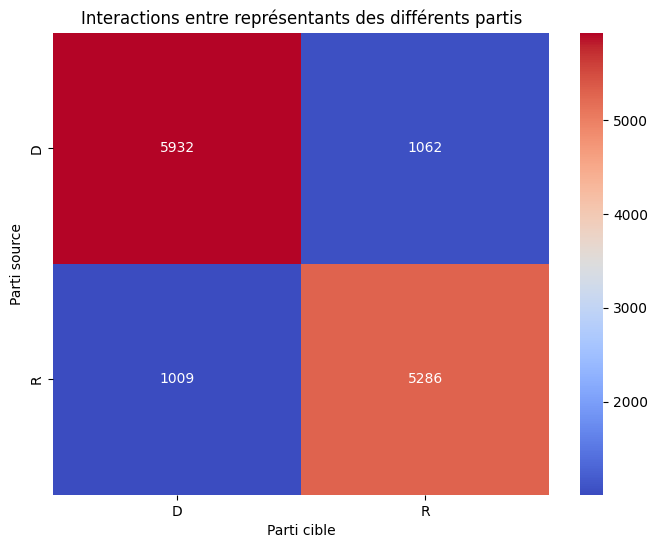

In [54]:
# Créer un dictionnaire associant les noms d'utilisateurs au parti
party_dict = {username: data.loc[username, 'party'] for username in usernameList}

# Initialiser un DataFrame pour les interactions entre partis
parties = attributes_df['party'].unique()
interaction_matrix = pd.DataFrame(0, index=parties, columns=parties)

# Calculer les interactions entre les représentants des différents partis
for i, out_edges in enumerate(outList):
    source_party = party_dict[usernameList[i]]
    
    for j, target in enumerate(out_edges):
        target_party = party_dict[usernameList[target]]
        
        # Incrémenter le compteur de la matrice d'interaction
        interaction_matrix.loc[source_party, target_party] += 1

# Créer un graphique de la matrice de confusion des interactions entre partis
plt.figure(figsize=(8, 6))
sns.heatmap(interaction_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title("Interactions entre représentants des différents partis")
plt.xlabel("Parti cible")
plt.ylabel("Parti source")
plt.show()

/var/folders/v4/6pdcd6_s5c9c0f6cpb908t8c0000gn/T/ipykernel_80645/916627808.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.002105263157894737' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weighted_interaction_matrix.loc[source_party, target_party] += weight
/var/folders/v4/6pdcd6_s5c9c0f6cpb908t8c0000gn/T/ipykernel_80645/916627808.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.002105263157894737' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weighted_interaction_matrix.loc[source_party, target_party] += weight


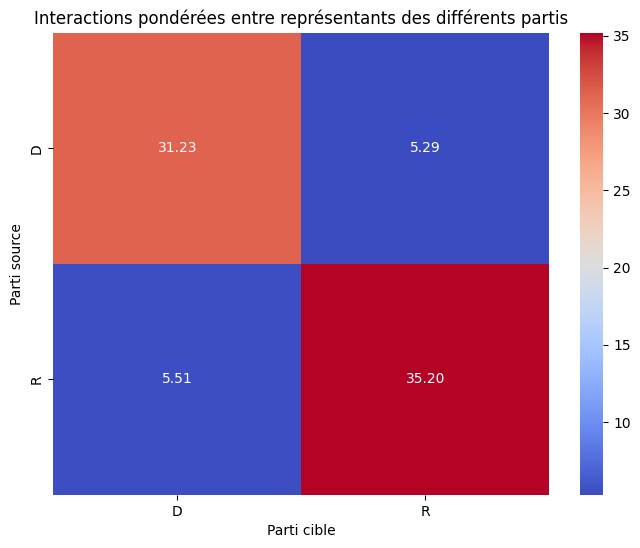

In [55]:
# Créer un dictionnaire associant les noms d'utilisateurs au parti
party_dict = {username: data.loc[username, 'party'] for username in usernameList}

# Initialiser un DataFrame pour les interactions pondérées entre partis
parties = attributes_df['party'].unique()
weighted_interaction_matrix = pd.DataFrame(0, index=parties, columns=parties)

# Calculer les interactions pondérées entre les représentants des différents partis
for i, out_edges in enumerate(outList):
    source_party = party_dict[usernameList[i]]
    
    for j, target in enumerate(out_edges):
        target_party = party_dict[usernameList[target]]
        
        # Obtenir le poids de l'interaction
        weight = outWeight[i][j]
        
        # Ajouter le poids à la matrice d'interactions pondérée
        weighted_interaction_matrix.loc[source_party, target_party] += weight

# Créer un graphique de la matrice d'interactions pondérée entre partis
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_interaction_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Interactions pondérées entre représentants des différents partis")
plt.xlabel("Parti cible")
plt.ylabel("Parti source")
plt.show()

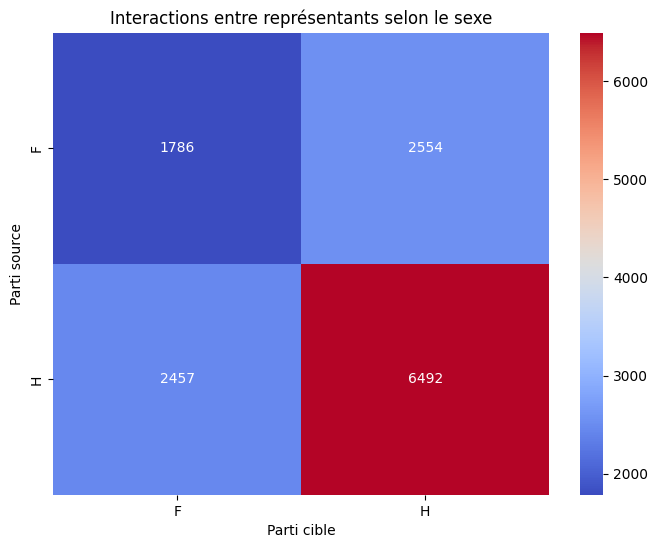

In [56]:
# Créer un dictionnaire associant les noms d'utilisateurs au parti
party_dict = {username: data.loc[username, 'sex'] for username in usernameList}

# Initialiser un DataFrame pour les interactions entre partis
parties = attributes_df['sex'].unique()
interaction_matrix = pd.DataFrame(0, index=parties, columns=parties)

# Calculer les interactions entre les représentants des différents partis
for i, out_edges in enumerate(outList):
    source_party = party_dict[usernameList[i]]
    
    for j, target in enumerate(out_edges):
        target_party = party_dict[usernameList[target]]
        
        # Incrémenter le compteur de la matrice d'interaction
        interaction_matrix.loc[source_party, target_party] += 1

# Créer un graphique de la matrice de confusion des interactions entre partis
plt.figure(figsize=(8, 6))
sns.heatmap(interaction_matrix, annot=True, cmap='coolwarm', fmt='d')
plt.title("Interactions entre représentants selon le sexe")
plt.xlabel("Parti cible")
plt.ylabel("Parti source")
plt.show()

### Structure du réseau

Densité du réseau : 0.0590
Le réseau n'est pas fortement connecté, impossible de calculer le diamètre.


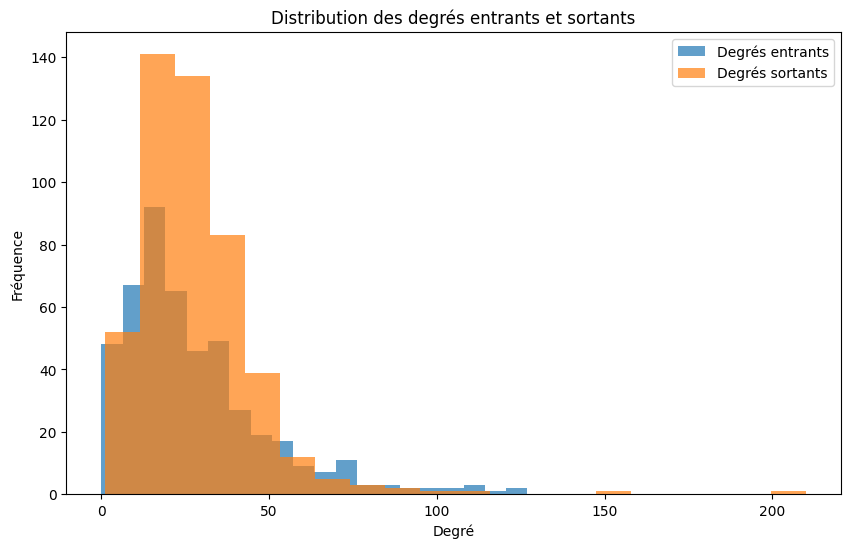


Interprétations:
1. La densité du réseau est de 0.0590, indiquant que le réseau est relativement spars.
2. Le réseau n'est pas fortement connecté, ce qui signifie qu'il y a des composants faibles (parties déconnectées).
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres, ce qui peut être dû à des rôles spécifiques ou à la notoriété des représentants.


In [57]:
# Créer un graphe dirigé avec NetworkX
G = nx.DiGraph()

# Ajouter les nœuds et les arêtes avec leurs poids
for i, out_edges in enumerate(outList):
    source = usernameList[i]
    
    for j, target in enumerate(out_edges):
        weight = outWeight[i][j]
        target_user = usernameList[target]
        G.add_edge(source, target_user, weight=weight)

# Calculer la densité du réseau
density = nx.density(G)
print(f"Densité du réseau : {density:.4f}")

# Calculer le diamètre du réseau
if nx.is_strongly_connected(G):
    diameter = nx.diameter(G)
    print(f"Diamètre du réseau : {diameter}")
else:
    print("Le réseau n'est pas fortement connecté, impossible de calculer le diamètre.")

# Calculer la distribution des degrés
in_degrees = [G.in_degree(node) for node in G.nodes()]
out_degrees = [G.out_degree(node) for node in G.nodes()]

# Tracer la distribution des degrés entrants et sortants
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=20, alpha=0.7, label='Degrés entrants')
plt.hist(out_degrees, bins=20, alpha=0.7, label='Degrés sortants')
plt.title("Distribution des degrés entrants et sortants")
plt.xlabel("Degré")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

# Interprétation des caractéristiques topologiques
print("\nInterprétations:")
print(f"1. La densité du réseau est de {density:.4f}, indiquant que le réseau est relativement { 'dense' if density > 0.1 else 'sparse'}.")

if nx.is_strongly_connected(G):
    print(f"2. Le diamètre du réseau est de {diameter}, indiquant que la distance maximale entre deux nœuds est { 'petite' if diameter <= 5 else 'grande'}.")
else:
    print("2. Le réseau n'est pas fortement connecté, ce qui signifie qu'il y a des composants faibles (parties déconnectées).")

print("3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres, ce qui peut être dû à des rôles spécifiques ou à la notoriété des représentants.")


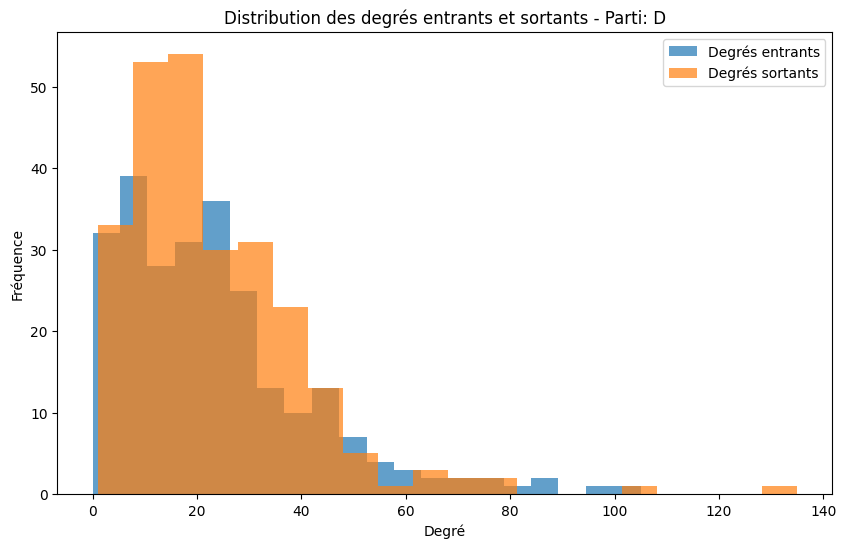


Segment: Parti: D
1. Densité du segment : 0.0938
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


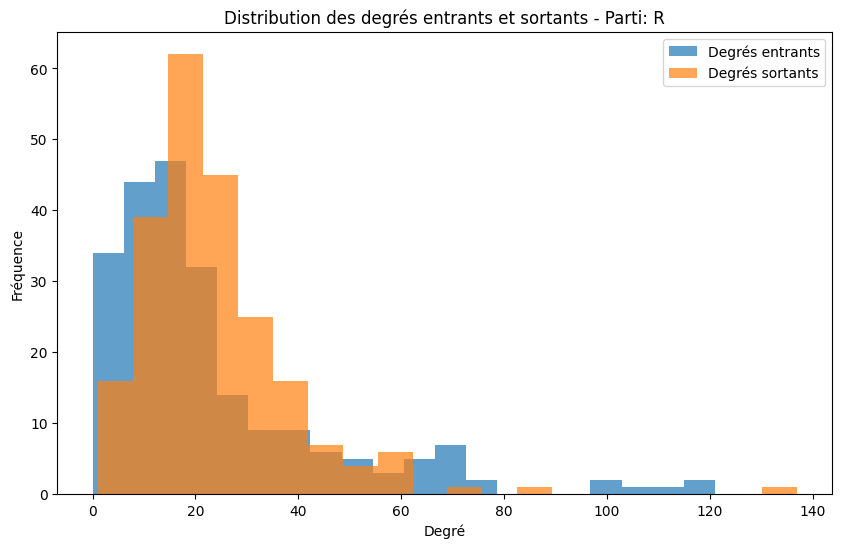


Segment: Parti: R
1. Densité du segment : 0.1068
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


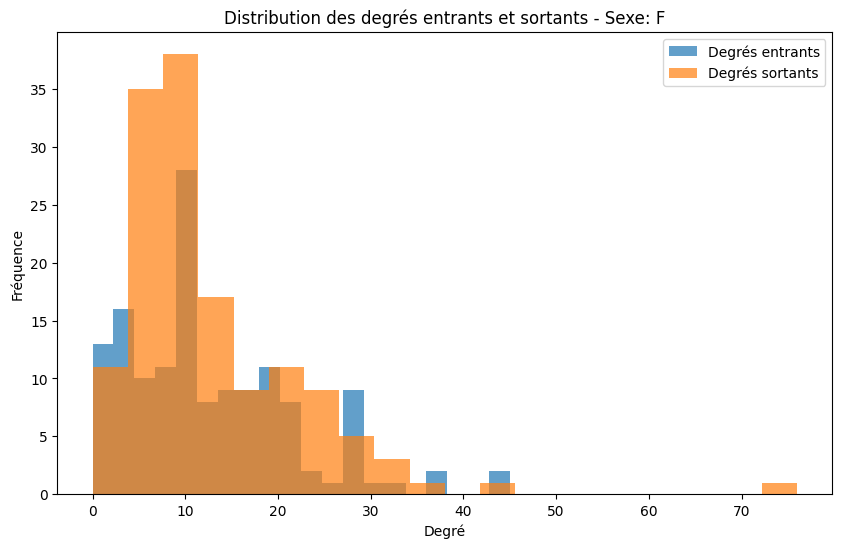


Segment: Sexe: F
1. Densité du segment : 0.0905
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


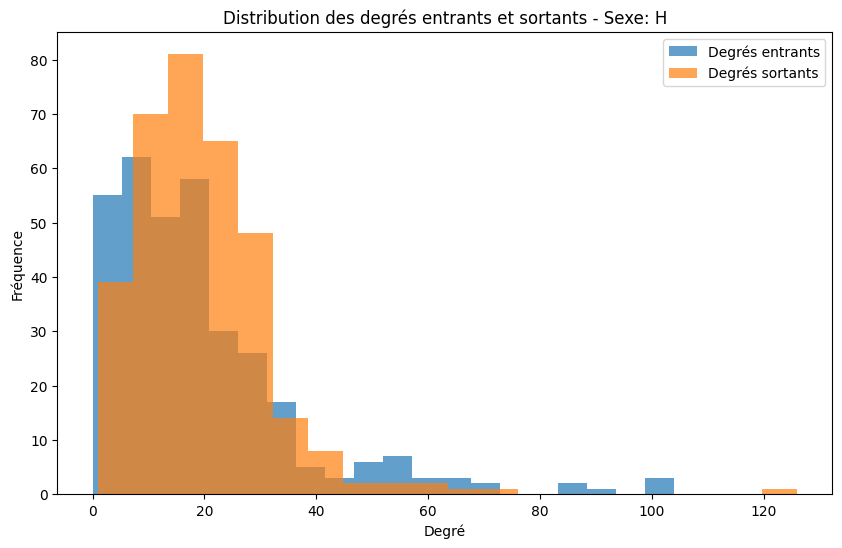


Segment: Sexe: H
1. Densité du segment : 0.0584
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


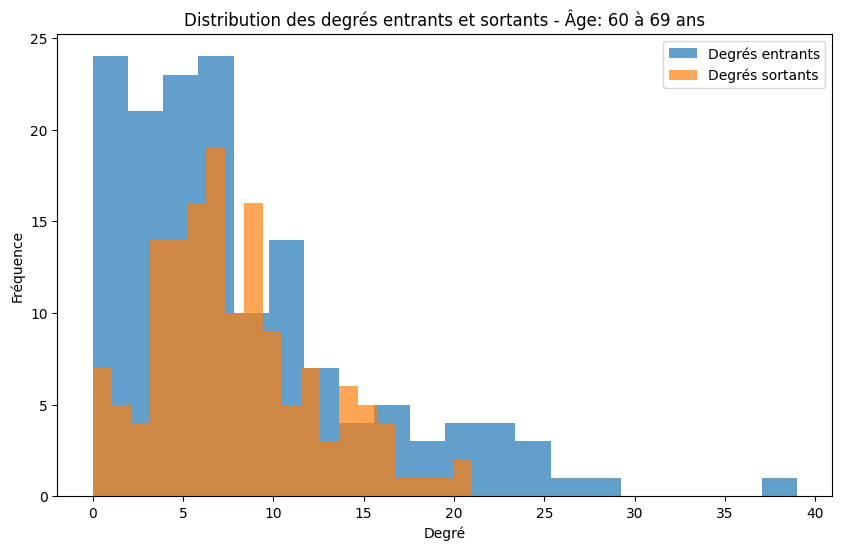


Segment: Âge: 60 à 69 ans
1. Densité du segment : 0.0541
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


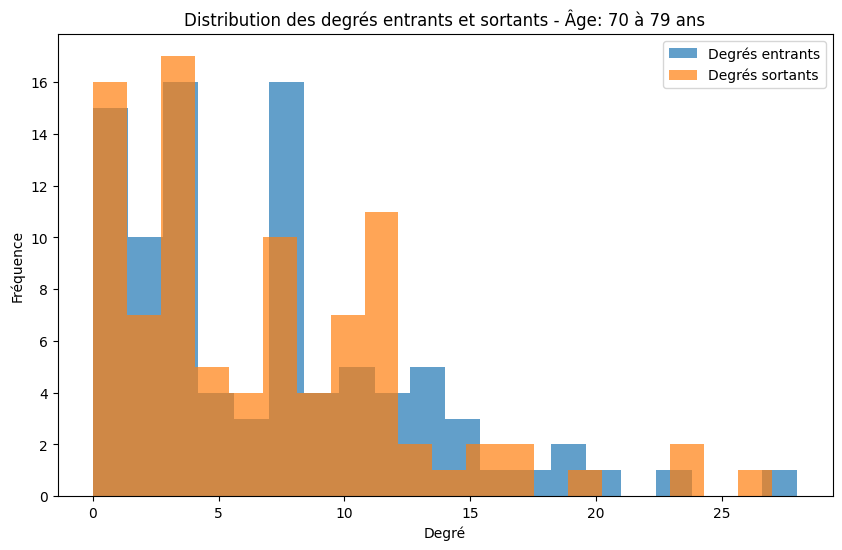


Segment: Âge: 70 à 79 ans
1. Densité du segment : 0.0758
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


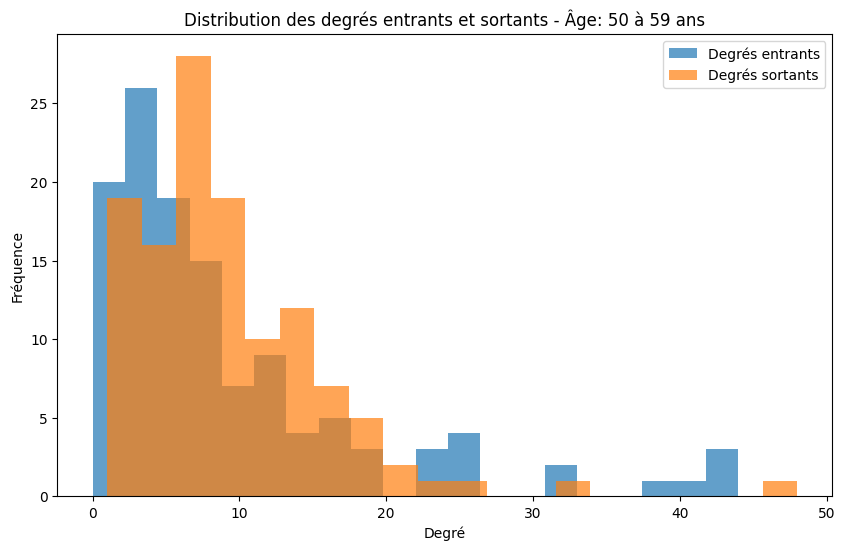


Segment: Âge: 50 à 59 ans
1. Densité du segment : 0.0773
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


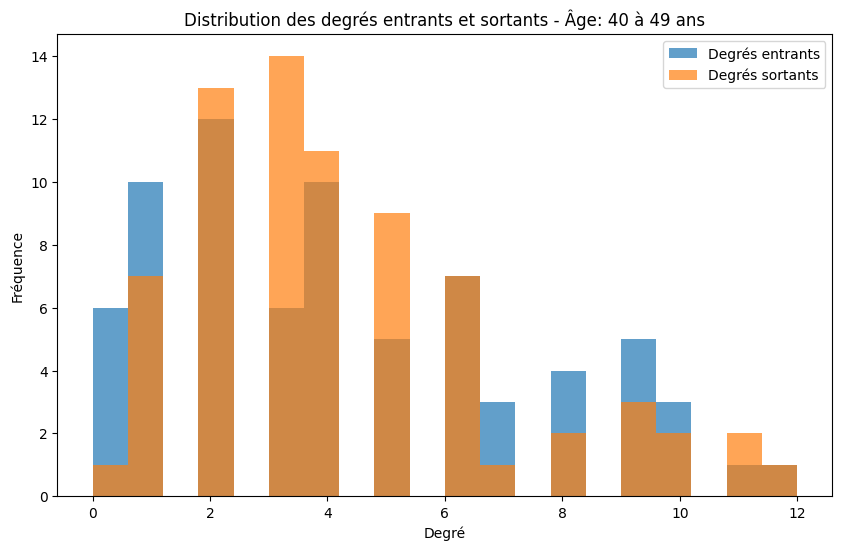


Segment: Âge: 40 à 49 ans
1. Densité du segment : 0.0590
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


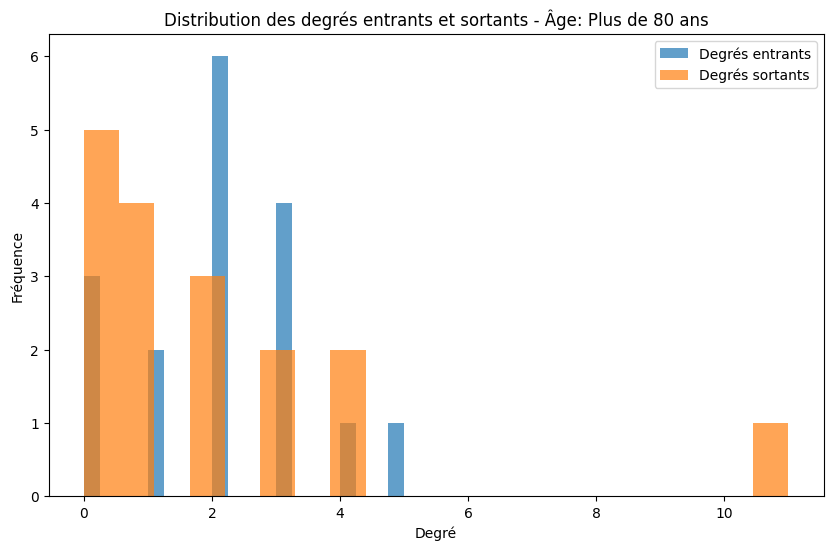


Segment: Âge: Plus de 80 ans
1. Densité du segment : 0.1287
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


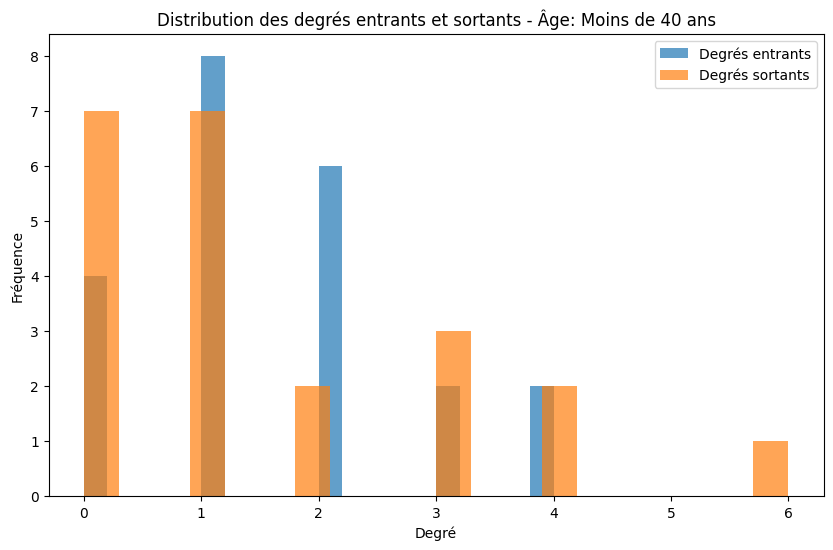


Segment: Âge: Moins de 40 ans
1. Densité du segment : 0.0736
2. Diamètre du segment : Non applicable (sous-graphe non fortement connecté)
3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.


In [58]:
# Créer un graphe dirigé avec NetworkX
G = nx.DiGraph()

# Ajouter les nœuds et les arêtes avec leurs poids
for i, out_edges in enumerate(outList):
    source = usernameList[i]
    
    for j, target in enumerate(out_edges):
        weight = outWeight[i][j]
        target_user = usernameList[target]
        G.add_edge(source, target_user, weight=weight)

# Diviser les représentants par parti, sexe et âge
parties = attributes_df['party'].unique()
sexes = attributes_df['sex'].unique()
ages = attributes_df['age_recode'].unique()

# Fonction pour analyser un segment du réseau
def analyze_segment(segment_nodes, segment_name):
    # Créer un sous-graphe pour le segment
    
    subgraph = G.subgraph(segment_nodes)
    
    # Calculer la densité du sous-graphe
    density = nx.density(subgraph)
    
    # Calculer le diamètre du sous-graphe
    if nx.is_strongly_connected(subgraph):
        diameter = nx.diameter(subgraph)
    else:
        diameter = "Non applicable (sous-graphe non fortement connecté)"
    
    # Calculer la distribution des degrés entrants et sortants
    in_degrees = [subgraph.in_degree(node) for node in subgraph.nodes()]
    out_degrees = [subgraph.out_degree(node) for node in subgraph.nodes()]
    
    # Tracer la distribution des degrés
    plt.figure(figsize=(10, 6))
    plt.hist(in_degrees, bins=20, alpha=0.7, label='Degrés entrants')
    plt.hist(out_degrees, bins=20, alpha=0.7, label='Degrés sortants')
    plt.title(f"Distribution des degrés entrants et sortants - {segment_name}")
    plt.xlabel("Degré")
    plt.ylabel("Fréquence")
    plt.legend()
    plt.show()
    
    # Interprétation des caractéristiques topologiques
    print(f"\nSegment: {segment_name}")
    print(f"1. Densité du segment : {density:.4f}")
    print(f"2. Diamètre du segment : {diameter}")
    print(f"3. La distribution des degrés entrants et sortants montre des pics autour de certains degrés. Cela peut indiquer que certains nœuds ont beaucoup plus ou beaucoup moins de connexions que d'autres.")

# Analyser les segments par parti
for party in parties:
    segment_nodes = data[data['party'] == party].index.tolist()
    analyze_segment(segment_nodes, f"Parti: {party}")

# Analyser les segments par sexe
for sex in sexes:
    segment_nodes = data[data['sex'] == sex].index.tolist()
    analyze_segment(segment_nodes, f"Sexe: {sex}")

# Analyser les segments par tranches d'âge (age_recode)
for age in ages:
    segment_nodes = data[data['age_recode'] == age].index.tolist()
    analyze_segment(segment_nodes, f"Âge: {age}")




### Distribution des poids

In [107]:
attributes_df["congress_member"] = usernameList


['SenatorBaldwin',
 'SenJohnBarrasso',
 'SenatorBennet',
 'MarshaBlackburn',
 'SenBlumenthal',
 'RoyBlunt',
 'CoryBooker',
 'JohnBoozman',
 'SenatorBraun',
 'SenSherrodBrown',
 'SenatorCantwell',
 'SenCapito',
 'SenatorCardin',
 'SenatorCarper',
 'SenBobCasey',
 'SenBillCassidy',
 'ChrisCoons',
 'JohnCornyn',
 'SenCortezMasto',
 'SenTomCotton',
 'SenKevinCramer',
 'MikeCrapo',
 'SenTedCruz',
 'SteveDaines',
 'SenDuckworth',
 'SenatorDurbin',
 'SenJoniErnst',
 'SenFeinstein',
 'SenatorFischer',
 'SenGillibrand',
 'LindseyGrahamSC',
 'ChuckGrassley',
 'SenatorHagerty',
 'SenatorHassan',
 'HawleyMO',
 'MartinHeinrich',
 'SenatorHick',
 'maziehirono',
 'SenJohnHoeven',
 'SenHydeSmith',
 'JimInhofe',
 'SenRonJohnson',
 'timkaine',
 'SenMarkKelly',
 'SenJohnKennedy',
 'SenAngusKing',
 'SenAmyKlobuchar',
 'SenatorLankford',
 'SenatorLeahy',
 'SenMikeLee',
 'SenatorLujan',
 'SenLummis',
 'Sen_JoeManchin',
 'SenMarkey',
 'SenatorMenendez',
 'SenJeffMerkley',
 'JerryMoran',
 'lisamurkowski',
 'C

<Axes: >

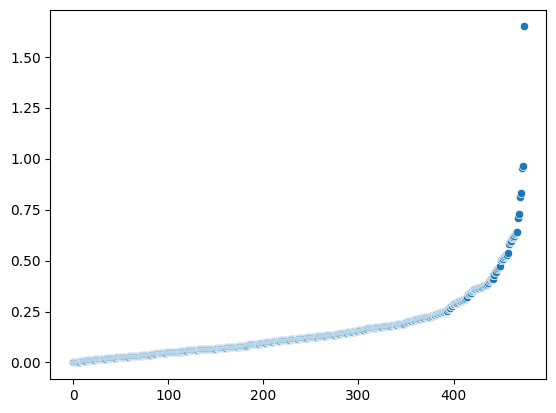

In [120]:

str_df = pd.DataFrame([sum(i) for i in inWeight], usernameList, columns= ["in_strength"])
str_df["out_strength"] = [sum(i) for i in outWeight]

sns.scatterplot(sorted(str_df["in_strength"]))
#so.Plot(str_df, x = str_df.index, y="in_strength").add(so.Dot(), so.Dodge(), so.Jitter(.3))


<Axes: >

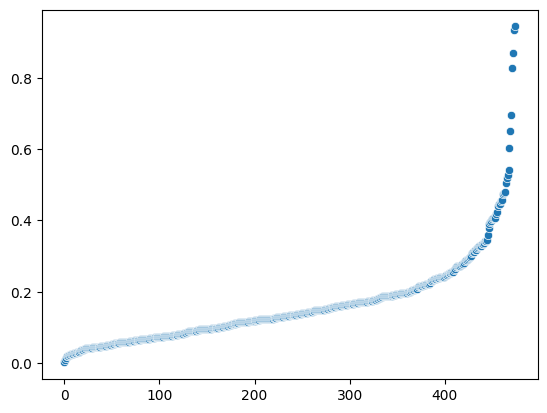